# Based Models

In [1]:
# Importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Reading Dataset and New Time Features

In [2]:
# Reading file (train_shuffled_with_columns.csv is result of shuffling the original train.csv file)
dataset = r'train_shuffled.csv' 
df = pd.read_csv(dataset,nrows=1000000)

# Rename column 'hour' to 'timestamp'
df.rename(columns={'hour':'timestamp'}, inplace=True)

# Convert 'timestamp' column to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%y%m%d%H')

# Sorting rows per 'hour'
df = df.sort_values(by='timestamp')
df.head(2)

,id,click,timestamp,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
325876,15348754204581273148,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15705,320,50,1722,0,35,-1,79
876704,8920252239684887372,0,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,e2fcccd2,5c5a694b,...,1,0,4687,320,50,423,2,39,100148,32


In [3]:
# Creating new features

# time related features
df['date'] = df['timestamp'].dt.strftime('%Y-%m-%d') # yyyy-mm-dd
df['day_of_week'] = df['timestamp'].dt.dayofweek # 0: monday... 6: sunday
df['hour'] = df['timestamp'].dt.hour # 0-23

# num_impressions_user_day: Number of impressions a user (device_id) has in a day
df['num_impressions_user_day'] = df.groupby(['date', 'device_id'])['id'].transform('count')

# time_interval_last_visit: Time interval from the last visit
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values(by=['device_id', 'timestamp'], inplace=True)
df['time_interval_last_visit'] = df.groupby('device_id')['timestamp'].diff().dt.total_seconds().fillna(0)

# num_days_user_appears: Number of days the user appeared
df['num_days_user_appears'] = df.groupby('device_id')['date'].transform('nunique')

# num_previous_clicks: number of clicks the user has done 
df['num_previous_clicks'] = df.groupby('device_id')['click'].cumsum() - df['click']

print('new features created')

new features created


In [4]:
# Dropping columns 'id' and 'timestamp'
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)
    print('column id was deleted')

if 'timestamp' in df.columns:
    df.drop(columns=['timestamp'], inplace=True)
    print('column timestamp was deleted')

column id was deleted
column timestamp was deleted


# Adressing imbalance problem: Downsampling majority class = 0

In [5]:
# Separate majority and minority classes
df_majority = df[df['click'] == 0]
df_minority = df[df['click'] == 1]

# Downsample majority class
df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the DataFrame
df = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class counts
print(df['click'].value_counts())

click
1    169554
0    169554
Name: count, dtype: int64


In [6]:
# Summary of Number of unique values and data type per column
summary = pd.DataFrame(df.nunique(), columns=['num_unique'])
summary['dtype'] = df.dtypes
summary

,num_unique,dtype
click,2,int64
C1,7,int64
banner_pos,7,int64
site_id,2065,object
site_domain,2060,object
site_category,20,object
app_id,2089,object
app_domain,146,object
app_category,22,object
device_id,52611,object


In [7]:
df.shape

(339108, 29)

In [8]:
variable_types = {
    'click': 'target',
    'C1': 'categorical nominal to encode',
    'banner_pos': 'categorical ready to use',
    'site_id': 'categorical nominal to encode',
    'site_domain': 'categorical nominal to encode',
    'site_category': 'categorical nominal to encode',
    'app_id': 'categorical nominal to encode',
    'app_domain': 'categorical nominal to encode',
    'app_category': 'categorical nominal to encode',
    'device_id': 'categorical nominal to encode',
    'device_ip': 'categorical nominal to encode',
    'device_model': 'categorical nominal to encode',
    'device_type': 'categorical ready to use',
    'device_conn_type': 'categorical ready to use',
    'C14': 'categorical nominal to encode',
    'C15': 'categorical ready to use',
    'C16': 'categorical ready to use',
    'C17': 'categorical ready to use',
    'C18': 'categorical ready to use',
    'C19': 'categorical ready to use',
    'C20': 'categorical nominal to encode', # Most popular label is '-1' and the others have a format like this '100098'
    'C21': 'categorical ready to use',
    'date': 'categorical ordinal to encode',
    'day_of_week': 'categorical ordinal to encode',
    'hour': 'categorical ready to use',
    'num_impressions_user_day': 'numerical',
    'time_interval_last_visit': 'numerical',
    'num_days_user_appears': 'numerical',
    'num_previous_clicks': 'numerical'
}

In [9]:
def check_repeated_counts(counts_dict):
    """
    Function to check for repeated count values in a counts dictionary.
    
    Args:
    counts_dict (dict): A dictionary where the keys are the categories and the values are the counts.
    
    Returns:
    bool: True if there are repeated counts, False otherwise.
    """
    unique_counts = set(counts_dict.values())
    return len(unique_counts) != len(counts_dict)

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import FeatureHasher

def power_of_2(x):
    if x > 6000:
        return (2 ** (int(np.log2(x)) - 13))
    elif x > 500:
        return (2 ** (int(np.log2(x)) - 5))
    elif x > 100:
        return (2 ** (int(np.log2(x)) - 2))
    else:
        return (2 ** (int(np.log2(x))))


def encode_categorical_column(column, column_type, n_features=None):
    """
    Encode a single categorical column based on its type.

    Args:
    column (Series): The Series containing the categorical data.
    column_type (str): The type of the column.
    n_features (int, optional): The number of features for feature hashing.

    Returns:
    Series: The encoded categorical column.
    """
    encoded_column = column.copy()
    
    if column_type == 'categorical ordinal to encode':
        # Apply label encoding
        label_encoder = LabelEncoder()
        encoded_column = label_encoder.fit_transform(encoded_column)
        print(f"Column {column.name} has been encoded with method: Label encoding")
    elif column_type == 'categorical nominal to encode':
        # Check for repeated counts
        counts_dict = column.value_counts().to_dict()
        repeated_counts = check_repeated_counts(counts_dict)
        if not repeated_counts:
            # Apply count frequency encoding
            encoded_column = column.map(column.value_counts())
            print(f"Column {column.name} has been encoded with method: Count Encoding")
        else:
            # Apply feature hashing
            if n_features is None:
                # Calculate the nearest power of 2 less than the number of unique values
                n_features = power_of_2(len(column.unique()))
                n_features = int(n_features)  # Convert to integer
                print(f"Column {column.name} will be encoded with method: Feature Hashing with n_features={n_features}")
            # Convert each element in the column to a string and wrap it in a list
            column_strings = column.astype(str).apply(lambda x: [x])
            hasher = FeatureHasher(n_features=n_features, input_type='string')
            hashed_features = hasher.fit_transform(column_strings)
            encoded_column = pd.Series(hashed_features.toarray().tolist())
            print(f"Column {column.name} has been encoded with method: Feature Hashing")
    else:
        raise ValueError("Invalid column type. Must be 'categorical ordinal to encode' or 'categorical nominal to encode'.")
    
    return encoded_column

In [11]:
# Create a new DataFrame to store the encoded columns
df_encoded = pd.DataFrame()

# Iterate over each column in the original DataFrame
for column_name, column_type in variable_types.items():
    # Check if the column needs encoding
    if column_type in ['categorical ordinal to encode', 'categorical nominal to encode']:
        # Encode the column
        encoded_column = encode_categorical_column(df[column_name], column_type)
        # Add the encoded column to the new DataFrame
        df_encoded[column_name] = encoded_column
    else:
        # For non-categorical columns, simply copy them to the new DataFrame
        df_encoded[column_name] = df[column_name]

# Display the encoded DataFrame
print('df was encoded successfully')

Column C1 has been encoded with method: Count Encoding
Column site_id will be encoded with method: Feature Hashing with n_features=64
Column site_id has been encoded with method: Feature Hashing
Column site_domain will be encoded with method: Feature Hashing with n_features=64
Column site_domain has been encoded with method: Feature Hashing
Column site_category has been encoded with method: Count Encoding
Column app_id will be encoded with method: Feature Hashing with n_features=64
Column app_id has been encoded with method: Feature Hashing
Column app_domain will be encoded with method: Feature Hashing with n_features=32
Column app_domain has been encoded with method: Feature Hashing
Column app_category will be encoded with method: Feature Hashing with n_features=16
Column app_category has been encoded with method: Feature Hashing
Column device_id will be encoded with method: Feature Hashing with n_features=4
Column device_id has been encoded with method: Feature Hashing
Column device_

In [18]:
df_encoded.shape

(339108, 29)

### Splitting Features and Target

In [31]:
# Columns encoded with feature hashing and their respective n_features
columns_to_hash = {
    'site_id': 64,
    'site_domain': 64,
    'app_id': 64,
    'app_domain': 32,
    'app_category': 16,
    'device_id': 4,
    'device_ip': 16,
    'device_model': 128,
    'C14': 32,
    'C20': 32
}

# Function to apply feature hashing and one-hot encoding
def flatten_categorical(df, column, n_features):
    # Apply feature hashing
    hashed_features = df[column].apply(lambda x: hash(str(x)) % n_features)
    
    # Convert hashed features into binary columns using one-hot encoding
    one_hot_encoded = pd.get_dummies(hashed_features, prefix=column)
    
    return one_hot_encoded

# Flatten categorical variables using feature hashing and one-hot encoding
flattened_categorical = []
for column, n_features in columns_to_hash.items():
    flattened_categorical.append(flatten_categorical(df_encoded, column, n_features))

# Concatenate flattened categorical variables with the original dataframe
df_encoded_flattened = pd.concat([df_encoded] + flattened_categorical, axis=1)

# Remove original categorical columns
df_encoded_flattened.drop(columns=columns_to_hash.keys(), inplace=True)

# Display the resulting dataframe
print(df_encoded_flattened.head())


   click      C1  banner_pos  site_category  device_type  device_conn_type  \
0      1  311011           0          67258            1                 0   
1      0  311011           1         108536            1                 2   
2      0  311011           1         108536            1                 0   
3      0   20535           0         125688            0                 0   
4      1  311011           0         125688            1                 2   

   C15  C16   C17  C18  C19  C21  date  day_of_week  hour  \
0  320   50  2512    2  303   52     1            2    13   
1  320   50  1991    2   39   33     6            0     5   
2  320   50  2526    3  167  221     2            3     8   
3  320   50   549    3   39   23     2            3    22   
4  320   50  1248    2   39   13     0            1    16   

   num_impressions_user_day  time_interval_last_visit  num_days_user_appears  \
0                    107902                       0.0                     10   
1   

In [33]:
# Separate features and target
X = df_encoded_flattened.drop('click', axis=1)  # Features
y = df_encoded_flattened['click']  # Target

# LR-TruncatedSVD

In [34]:
# TruncatedSVD for dimensionality reduction on sparse input
from sklearn.decomposition import TruncatedSVD

# Initialize TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=42)

# Fit and transform the sparse data
X_svd = svd.fit_transform(X)

# Create a new DataFrame with the principal components
df_svd = pd.DataFrame(data=X_svd, columns=['PC1', 'PC2'])

# Concatenate the principal components DataFrame with the target variable
df_svd['click'] = df_downsampled['click'].values

# Display the first few rows of the TruncatedSVD DataFrame
print(df_svd.head())

             PC1           PC2  click
0  331753.768008  -7731.078834      0
1  345716.875898   -811.428154      0
2  339213.767230  24956.924484      0
3   54671.258330  93077.078447      0
4  319174.888205  83159.022749      0


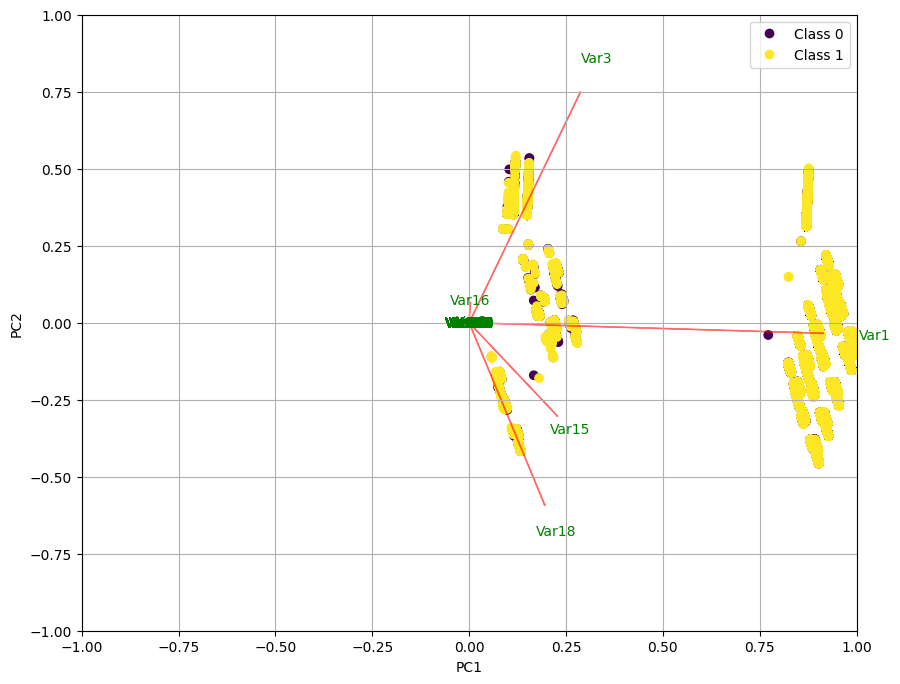

In [35]:
import matplotlib.pyplot as plt

# Plot Biplot
def biplot_encoded(score, coeff, labels=None):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    scatter = plt.scatter(xs * scalex, ys * scaley, c=df_svd['click'], cmap='viridis') 
    for i in range(n):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.5)
        if labels is None:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, "Var" + str(i + 1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, labels[i], color='g', ha='center', va='center')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()
    plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])

# Plotting the biplot using pre-calculated principal components
plt.figure(figsize=(10, 8))
biplot_encoded(df_svd[['PC1', 'PC2']].values, np.transpose(svd.components_[0:2, :]))
plt.show()

## Splitting data in training and test (After SVD)

In [36]:
from sklearn.model_selection import train_test_split
# Split data into training and testing sets
X_train_svd, X_test_svd, y_train_svd, y_test_svd = train_test_split(X_svd, y , test_size=0.2, random_state=42)

## Splitting data in training and test (without SVD)

In [37]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X , y , test_size=0.2, random_state=42)

## LG (using features resulting from SVD)

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, log_loss, f1_score

# Fit logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train_svd, y_train_svd)

# Predict probabilities
y_prob = logreg.predict_proba(X_test_svd)

# Compute log loss
logloss_LR_SVD = log_loss(y_test_svd, y_prob)
print("Log Loss LG-SVD:", logloss_LR_SVD)

# Confusion Matrix
y_pred = logreg.predict(X_test_svd)
cm = confusion_matrix(y_test_svd, y_pred)
print("Confusion Matrix LG-SVD:")
print(cm)

# Compute TPR and FPR
TN_LR_SVD, FP_LR_SVD, FN_LR_SVD, TP_LR_SVD = cm.ravel()
TPR_LR_SVD = TP_LR_SVD / (TP_LR_SVD + FN_LR_SVD)
FPR_LR_SVD = FP_LR_SVD / (FP_LR_SVD + TN_LR_SVD)
print("True Positive Rate (TPR) LG-SVD:", TPR_LR_SVD)
print("False Positive Rate (FPR) LG-SVD:", FPR_LR_SVD)

# Compute F1-Score
f1_LR_SVD = f1_score(y_test, y_pred)
print("F1-Score (LG-SVD):", f1_LR_SVD)

Log Loss LG-SVD: 0.6908358605325698
Confusion Matrix LG-SVD:
[[18331 15580]
 [16109 17802]]
True Positive Rate (TPR) LG-SVD: 0.524962401580608
False Positive Rate (FPR) LG-SVD: 0.459437940491286
F1-Score (LG-SVD): 0.5290892069011636


# Without SVD (LR + Regulatization)

### Standarizing x

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, log_loss, f1_score
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit logistic regression model with regularization
C = 0.5  # Regularization parameter
logreg_regularized = LogisticRegression(C=C, penalty='l2')
logreg_regularized.fit(X_train_scaled, y_train)

# Predict probabilities
y_prob_regularized = logreg_regularized.predict_proba(X_test_scaled)

# Compute log loss
logloss_LR_regularized = log_loss(y_test, y_prob_regularized)
print("Log Loss (LR-Regularized):", logloss_LR_regularized)

# Confusion Matrix
y_pred_regularized = logreg_regularized.predict(X_test_scaled)
cm_regularized = confusion_matrix(y_test, y_pred_regularized)
print("Confusion Matrix (LR-Regularized):")
print(cm_regularized)

# Compute TPR and FPR
TN_reg, FP_reg, FN_reg, TP_reg = cm_regularized.ravel()
TPR_regularized = TP_reg / (TP_reg + FN_reg)
FPR_regularized = FP_reg / (FP_reg + TN_reg)
print("True Positive Rate (TPR) (LR-Regularized):", TPR_regularized)
print("False Positive Rate (FPR) (LR-Regularized):", FPR_regularized)

# Compute F1-Score
f1_LR_regularized = f1_score(y_test, y_pred_regularized)
print("F1-Score (LR-Regularized):", f1_LR_regularized)

Log Loss (LR-Regularized): 0.6200516394199673
Confusion Matrix (LR-Regularized):
[[20102 13809]
 [ 9590 24321]]
True Positive Rate (TPR) (LR-Regularized): 0.7172009082598567
False Positive Rate (FPR) (LR-Regularized): 0.40721299873197486
F1-Score (LR-Regularized): 0.6751988451020947


c:\Users\JULIANA ROJAS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Without standarizing x

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, log_loss, f1_score
from sklearn.preprocessing import StandardScaler

# Fit logistic regression model with regularization
C = 0.5  # Regularization parameter
logreg_regularized_nostd = LogisticRegression(C=C, penalty='l2')
logreg_regularized_nostd.fit(X_train, y_train)

# Predict probabilities
y_prob_regularized_nostd = logreg_regularized_nostd.predict_proba(X_test)

# Compute log loss
logloss_LR_regularized_nostd = log_loss(y_test, y_prob_regularized_nostd)
print("Log Loss (LR-Regularized) No Standarized:", logloss_LR_regularized_nostd)

# Confusion Matrix
y_pred_regularized_nostd = logreg_regularized_nostd.predict(X_test)
cm_regularized_nostd = confusion_matrix(y_test, y_pred_regularized_nostd)
print("Confusion Matrix (LR-Regularized) No Standarized :")
print(cm_regularized_nostd)

# Compute TPR and FPR
TN_reg_nostd, FP_reg_nostd, FN_reg_nostd, TP_reg_nostd = cm_regularized_nostd.ravel()
TPR_regularized_nostd = TP_reg_nostd / (TP_reg_nostd + FN_reg_nostd)
FPR_regularized_nostd = FP_reg_nostd / (FP_reg_nostd + TN_reg_nostd)
print("True Positive Rate (TPR) (LR-Regularized) No Standarized:", TPR_regularized_nostd)
print("False Positive Rate (FPR) (LR-Regularized) No Standarized:", FPR_regularized_nostd)

# Compute F1-Score
f1_LR_regularized_nostd = f1_score(y_test, y_pred_regularized_nostd)
print("F1-Score (LR-Regularized) No Standarized:", f1_LR_regularized_nostd)

c:\Users\JULIANA ROJAS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Log Loss (LR-Regularized) No Standarized: 0.6758160398843281
Confusion Matrix (LR-Regularized) No Standarized :
[[19992 13919]
 [14660 19251]]
True Positive Rate (TPR) (LR-Regularized) No Standarized: 0.5676918993836808
False Positive Rate (FPR) (LR-Regularized) No Standarized: 0.41045678393441654
F1-Score (LR-Regularized) No Standarized: 0.5739628210670681


# Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Predict probabilities
y_prob_rf = rf_classifier.predict_proba(X_test)

# Compute log loss
logloss_rf = log_loss(y_test, y_prob_rf)
print("Log Loss (Random Forest):", logloss_rf)

# Confusion Matrix
y_pred_rf = rf_classifier.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix (Random Forest):")
print(cm_rf)

# Compute TPR and FPR
TN_rf, FP_rf, FN_rf, TP_rf = cm_rf.ravel()
TPR_rf = TP_rf / (TP_rf + FN_rf)
FPR_rf = FP_rf / (FP_rf + TN_rf)
print("True Positive Rate (TPR) (Random Forest):", TPR_rf)
print("False Positive Rate (FPR) (Random Forest):", FPR_rf)

# Compute F1-Score
f1_rf = f1_score(y_test, y_pred_rf)
print("F1-Score (Random Forest):", f1_rf)

Log Loss (Random Forest): 0.6454591230615306
Confusion Matrix (Random Forest):
[[21693 12218]
 [10896 23015]]
True Positive Rate (TPR) (Random Forest): 0.6786883312199581
False Positive Rate (FPR) (Random Forest): 0.36029606912211376
F1-Score (Random Forest): 0.6657121369894712


# XGBoost

In [42]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

# Initialize XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
xgb_classifier.fit(X_train, y_train)

# Predict probabilities
y_prob_xgb = xgb_classifier.predict_proba(X_test)

# Compute log loss
logloss_xgb = log_loss(y_test, y_prob_xgb)
print("Log Loss (XGBoost):", logloss_xgb)

# Confusion Matrix
y_pred_xgb = xgb_classifier.predict(X_test)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix (XGBoost):")
print(cm_xgb)

# Compute TPR and FPR
TN_xgb, FP_xgb, FN_xgb, TP_xgb = cm_xgb.ravel()
TPR_xgb = TP_xgb / (TP_xgb + FN_xgb)
FPR_xgb = FP_xgb / (FP_xgb + TN_xgb)
print("True Positive Rate (TPR) (XGBoost):", TPR_xgb)
print("False Positive Rate (FPR) (XGBoost):", FPR_xgb)

# Compute F1-Score
f1_xgb = f1_score(y_test, y_pred_xgb)
print("F1-Score (XGBoost):", f1_xgb)

Log Loss (XGBoost): 0.5977912861922345
Confusion Matrix (XGBoost):
[[21346 12565]
 [ 9206 24705]]
True Positive Rate (TPR) (XGBoost): 0.7285246675120167
False Positive Rate (FPR) (XGBoost): 0.370528736987998
F1-Score (XGBoost): 0.6941459097231002


# Feed Forward Neural Network

In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, log_loss, roc_auc_score, f1_score

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model_fnn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_fnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_fnn.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, accuracy = model_fnn.evaluate(X_test_scaled, y_test)
print("Test Accuracy:", accuracy)

# Predict probabilities on test set
y_pred_probs = model_fnn.predict(X_test_scaled)

# Convert probabilities to binary predictions
y_pred = np.round(y_pred_probs)

# Calculate log loss
logloss_fnn = log_loss(y_test, y_pred_probs)
print("Log Loss FNN:", logloss_fnn)

# Confusion Matrix
cm_fnn = confusion_matrix(y_test, y_pred)
print("Confusion Matrix FNN:")
print(cm_fnn)

# Compute TPR and FPR
TN_fnn, FP_fnn, FN_fnn, TP_fnn = cm_fnn.ravel()
TPR_fnn = TP_fnn / (TP_fnn + FN_fnn)
FPR_fnn = FP_fnn / (FP_fnn + TN_fnn)
print("True Positive Rate (TPR) (FNN):", TPR_fnn)
print("False Positive Rate (FPR) (FNN):", FPR_fnn)

# Calculate F1-score
f1_fnn = f1_score(y_test, y_pred)
print("F1-score FNN:", f1_fnn)

Epoch 1/10
7630/7630 [==============================] - 16s 2ms/step - loss: 0.6216 - accuracy: 0.6519 - val_loss: 0.6102 - val_accuracy: 0.6586
Epoch 2/10
7630/7630 [==============================] - 14s 2ms/step - loss: 0.6059 - accuracy: 0.6674 - val_loss: 0.6092 - val_accuracy: 0.6606
Epoch 3/10
7630/7630 [==============================] - 14s 2ms/step - loss: 0.5996 - accuracy: 0.6737 - val_loss: 0.6095 - val_accuracy: 0.6615
Epoch 4/10
7630/7630 [==============================] - 14s 2ms/step - loss: 0.5945 - accuracy: 0.6772 - val_loss: 0.6102 - val_accuracy: 0.6632
Epoch 5/10
7630/7630 [==============================] - 14s 2ms/step - loss: 0.5899 - accuracy: 0.6806 - val_loss: 0.6095 - val_accuracy: 0.6615
Epoch 6/10
7630/7630 [==============================] - 16s 2ms/step - loss: 0.5855 - accuracy: 0.6847 - val_loss: 0.6106 - val_accuracy: 0.6644
Epoch 7/10
7630/7630 [==============================] - 15s 2ms/step - loss: 0.5815 - accuracy: 0.6881 - val_loss: 0.6112 - val_ac

# NAFM (Neural Additive Factorization Model)

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import AUC
from sklearn.metrics import confusion_matrix, log_loss, roc_auc_score, f1_score

# Build the NAFM model
model_nafm = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_nafm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC()])

# Train the model
model_nafm.fit(X_train_scaled, y_train, epochs=5, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, accuracy, auc = model_nafm.evaluate(X_test_scaled, y_test)
print("Test Accuracy NAFM:", accuracy)

# Predict probabilities on test set
y_pred_probs = model_nafm.predict(X_test_scaled)

# Convert probabilities to binary predictions
y_pred = np.round(y_pred_probs)

# Calculate log loss
logloss_nafm = log_loss(y_test, y_pred_probs)
print("Log Loss NAFM:", logloss_nafm)

# Confusion Matrix
cm_nafm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix NAFM:")
print(cm_nafm)

# Compute TPR and FPR
TN_nafm, FP_nafm, FN_nafm, TP_nafm = cm_nafm.ravel()
TPR_nafm = TP_nafm / (TP_nafm + FN_nafm)
FPR_nafm = FP_nafm / (FP_nafm + TN_nafm)
print("True Positive Rate (TPR) (NAFM):", TPR_nafm)
print("False Positive Rate (FPR) (NAFM):", FPR_nafm)

# Calculate F1-score
f1_nafm = f1_score(y_test, y_pred)
print("F1-score NAFM:", f1_nafm)

Epoch 1/5
7630/7630 [==============================] - 19s 2ms/step - loss: 0.6229 - accuracy: 0.6497 - auc: 0.7056 - val_loss: 0.6128 - val_accuracy: 0.6597 - val_auc: 0.7189
Epoch 2/5
7630/7630 [==============================] - 24s 3ms/step - loss: 0.6076 - accuracy: 0.6658 - auc: 0.7258 - val_loss: 0.6111 - val_accuracy: 0.6579 - val_auc: 0.7212
Epoch 3/5
7630/7630 [==============================] - 17s 2ms/step - loss: 0.6024 - accuracy: 0.6709 - auc: 0.7321 - val_loss: 0.6099 - val_accuracy: 0.6634 - val_auc: 0.7231
Epoch 4/5
7630/7630 [==============================] - 19s 2ms/step - loss: 0.5981 - accuracy: 0.6745 - auc: 0.7373 - val_loss: 0.6099 - val_accuracy: 0.6640 - val_auc: 0.7234
Epoch 5/5
2120/2120 [==============================] - 3s 1ms/step - loss: 0.6086 - accuracy: 0.6676 - auc: 0.7260
Test Accuracy NAFM: 0.6676299571990967
2120/2120 [==============================] - 2s 1ms/step
Log Loss NAFM: 0.6085955469404722
Confusion Matrix NAFM:
[[20077 13834]
 [ 8708 25203

# Feature Importance

In [45]:
import numpy as np

def calculate_feature_importance(model, X):
    """
    Calculate feature importance based on the absolute weights of the connections between
    input features and the hidden layers of the given model.

    Parameters:
    - model: Trained machine learning model (e.g., neural network)
    - X: Input features (numpy array or pandas DataFrame)

    Returns:
    - feature_importance: Dictionary containing feature names and their importance scores
    """

    # Extracting the weights of the first layer (assuming the model is sequential)
    first_layer_weights = model.layers[0].get_weights()[0]

    # Calculate the absolute sum of weights for each feature
    feature_importance_scores = np.abs(first_layer_weights).sum(axis=1)

    # Get feature names (if X is a DataFrame)
    if isinstance(X, pd.DataFrame):
        feature_names = X.columns.tolist()
    else:
        # Assuming feature names are not available
        feature_names = [f'Feature_{i}' for i in range(X.shape[1])]

    # Create a dictionary to store feature importance scores
    feature_importance = dict(zip(feature_names, feature_importance_scores))

    # Sort feature importance scores in descending order
    feature_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}

    return feature_importance


In [46]:
feature_importance_nafm = calculate_feature_importance(model_nafm, X_test)

# Print feature importance scores
print('Feature Importance NAFM')
for feature, importance in feature_importance_nafm.items():
    print(f"Feature: {feature}, Importance Score: {importance}")

Feature Importance NAFM
Feature: C21, Importance Score: 12.920199394226074
Feature: banner_pos, Importance Score: 10.530192375183105
Feature: C1, Importance Score: 10.30858039855957
Feature: app_domain_4, Importance Score: 10.268423080444336
Feature: C16, Importance Score: 9.757711410522461
Feature: site_id_11, Importance Score: 9.64816665649414
Feature: site_domain_38, Importance Score: 9.445709228515625
Feature: app_id_31, Importance Score: 9.432743072509766
Feature: device_conn_type, Importance Score: 9.268265724182129
Feature: device_model_80, Importance Score: 9.08493423461914
Feature: site_domain_25, Importance Score: 8.979106903076172
Feature: time_interval_last_visit, Importance Score: 8.884367942810059
Feature: app_category_12, Importance Score: 8.863624572753906
Feature: C17, Importance Score: 8.792488098144531
Feature: site_domain_48, Importance Score: 8.7398681640625
Feature: site_domain_58, Importance Score: 8.726993560791016
Feature: num_days_user_appears, Importance Scor

In [47]:
feature_importance_fnn = calculate_feature_importance(model_fnn, X_test)

# Print feature importance scores
print('Feature Importance FNN')
for feature, importance in feature_importance_fnn.items():
    print(f"Feature: {feature}, Importance Score: {importance}")

Feature Importance FNN
Feature: app_domain_4, Importance Score: 37.98226547241211
Feature: app_category_5, Importance Score: 37.09345245361328
Feature: app_domain_26, Importance Score: 36.46052169799805
Feature: app_category_15, Importance Score: 34.329017639160156
Feature: banner_pos, Importance Score: 30.900882720947266
Feature: C21, Importance Score: 30.252845764160156
Feature: C16, Importance Score: 27.11301040649414
Feature: app_domain_10, Importance Score: 26.983028411865234
Feature: time_interval_last_visit, Importance Score: 26.917633056640625
Feature: C18, Importance Score: 24.852441787719727
Feature: hour, Importance Score: 24.252235412597656
Feature: site_id_11, Importance Score: 23.175161361694336
Feature: device_conn_type, Importance Score: 22.182838439941406
Feature: C17, Importance Score: 21.30621337890625
Feature: site_id_45, Importance Score: 21.29928207397461
Feature: site_category, Importance Score: 21.2786922454834
Feature: C1, Importance Score: 20.997047424316406
F

In [48]:
# Feature importance for logistic regression model

def calculate_feature_importance_logistic_regression(model, X):
    """
    Calculate feature importance based on the coefficients of a logistic regression model.

    Parameters:
    - model: Trained logistic regression model
    - X: Input features (numpy array or pandas DataFrame)

    Returns:
    - feature_importance: Dictionary containing feature names and their coefficients
    """

    # Get coefficients from the logistic regression model
    coefficients = model.coef_[0]

    # Get feature names (if X is a DataFrame)
    if isinstance(X, pd.DataFrame):
        feature_names = X.columns.tolist()
    else:
        # Assuming feature names are not available
        feature_names = [f'Feature_{i}' for i in range(X.shape[1])]

    # Create a dictionary to store feature importance scores
    feature_importance = dict(zip(feature_names, coefficients))

    # Sort feature importance scores based on coefficients
    feature_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}

    return feature_importance

In [49]:
feature_importance_logreg = calculate_feature_importance_logistic_regression(logreg, X_test)

# Print feature importance scores
print('Feature Importance Logistic Regression')
for feature, coefficient in feature_importance_logreg.items():
    print(f"Feature: {feature}, Coefficient: {coefficient}")

Feature Importance Logistic Regression
Feature: C1, Coefficient: -2.019410677754916e-08
Feature: banner_pos, Coefficient: -2.905413197654945e-06


# Summary (Original)

In [50]:
import pandas as pd

# Initialize an empty list to store model outcomes
model_outcomes_data = []

# Add logistic regression outcomes with SVD
model_outcomes_data.append({'Model': 'Logistic Regression + SVD',
                            'Log Loss': logloss_LR_SVD,
                            'TPR': TPR_LR_SVD,
                            'FPR': FPR_LR_SVD,
                            'F1-Score': f1_LR_SVD})

# Add logistic regression outcomes without PCA, with regularization
#model_outcomes_data.append({'Model': 'Logistic Regression + Regularization',
#                            'Log Loss': logloss_LR_regularized,
#                            'TPR': TPR_regularized,
#                            'FPR': FPR_regularized,
#                            'F1-Score': f1_LR_regularized})

# Add logistic regression without SVD, with regularization, No standarized inputs
model_outcomes_data.append({'Model': 'Logistic Regression + Regularization (No Standarized)',
                            'Log Loss': logloss_LR_regularized_nostd,
                            'TPR': TPR_regularized_nostd,
                            'FPR': FPR_regularized_nostd,
                            'F1-Score': f1_LR_regularized_nostd})

# Add random forest outcomes
model_outcomes_data.append({'Model': 'Random Forest',
                            'Log Loss': logloss_rf,
                            'TPR': TPR_rf,
                            'FPR': FPR_rf,
                            'F1-Score': f1_rf})

# Add XGBoost outcomes
model_outcomes_data.append({'Model': 'XGBoost',
                            'Log Loss': logloss_xgb,
                            'TPR': TPR_xgb,
                            'FPR': FPR_xgb,
                            'F1-Score': f1_xgb})

# Add FNN outcomes
model_outcomes_data.append({'Model': 'Feedforward Neural Network',
                            'Log Loss': logloss_fnn,
                            'TPR': TPR_fnn,
                            'FPR': FPR_fnn,
                            'F1-Score': f1_fnn})

# Add NAFM outcomes
model_outcomes_data.append({'Model': 'Neural Attentive Factorization Machine',
                            'Log Loss': logloss_nafm,
                            'TPR': TPR_nafm,
                            'FPR': FPR_nafm,
                            'F1-Score': f1_nafm})

# Create a DataFrame from the list of model outcomes
model_outcomes = pd.DataFrame(model_outcomes_data)

# Display the table
print(model_outcomes)

                                                   Model  Log Loss       TPR  \
0                              Logistic Regression + SVD  0.690836  0.524962   
1  Logistic Regression + Regularization (No Standarized)  0.675816  0.567692   
2                                          Random Forest  0.645459  0.678688   
3                                                XGBoost  0.597791  0.728525   
4                             Feedforward Neural Network  0.618004  0.731031   
5                 Neural Attentive Factorization Machine  0.608596  0.743210   

        FPR  F1-Score  
0  0.459438  0.529089  
1  0.410457  0.573963  
2  0.360296  0.665712  
3  0.370529  0.694146  
4  0.402819  0.685176  
5  0.407950  0.690985  
